# Phân tích Khám phá Dữ liệu (EDA) - Phiên bản Nâng cao

**Các cập nhật mới:**
1.  **Phân tích độ dài văn bản nâng cao:** Sử dụng biểu đồ Histogram (Linear/Log), Boxplot và CDF để xác định ngưỡng cắt (cutoff threshold) chính xác.
2.  **Tỷ lệ phần trăm chủ đề:** Sử dụng Pie Chart để đánh giá mức độ mất cân bằng dữ liệu.
3.  **WordCloud theo từng chủ đề:** Trực quan hóa từ khóa đặc trưng cho từng nhãn để kiểm tra chất lượng dữ liệu.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import math

# Cấu hình giao diện biểu đồ
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# Cấu hình đường dẫn
CURRENT_DIR = Path.cwd()
PROJECT_ROOT = CURRENT_DIR if (CURRENT_DIR / "data").exists() else CURRENT_DIR.parent
DATA_DIR = PROJECT_ROOT / "data" / "final"
JSONL_PATH = DATA_DIR / "nlp_dataset.jsonl"

print(f"Thư mục dữ liệu: {DATA_DIR}")

Thư mục dữ liệu: c:\Users\ASUS\Programming-Coding\Python\NLM\NLP_TC_Group4\data\final


# 1. TẢI VÀ KIỂM TRA DỮ LIỆU

In [2]:
if JSONL_PATH.exists():
    print("Đang đọc dữ liệu...")
    df = pd.read_json(JSONL_PATH, lines=True)
    
    # Xác định cột chứa nhãn
    target_col = 'label_name' if 'label_name' in df.columns else 'label'
    
    print(f"Kích thước bộ dữ liệu: {df.shape[0]} dòng, {df.shape[1]} cột")
    display(df.head())
else:
    print("Lỗi: Không tìm thấy file dữ liệu. Vui lòng kiểm tra lại.")

Đang đọc dữ liệu...
Kích thước bộ dữ liệu: 115188 dòng, 5 cột


,text,label_name,label_id,filename,raw_text
0,phân khu sôi_động Hội_chợ Mùa Thu 2025 diễn Tr...,Ẩm thực,0,AT_DT_1.txt,Một trong những phân khu sôi động nhất Hội chợ...
1,Chủ_đề ẩm_thực Hà_thành thu_hút . Dân_trí đăng...,Ẩm thực,0,AT_DT_10.txt,Chủ đề về ẩm thực Hà thành luôn thu hút sự qua...
2,quán bình_dân chợ đêm Vientiane Lào du_khách v...,Ẩm thực,0,AT_DT_100.txt,Một quán ăn bình dân ở chợ đêm Vientiane của L...
3,pizza thương_hiệu nổi_tiếng pizza hợp_tác phát...,Ẩm thực,0,AT_DT_101.txt,Loại pizza đặc biệt này được một thương hiệu n...
4,"chuyến đi Singapore , đoạn video cảnh tỷ_phú B...",Ẩm thực,0,AT_DT_102.txt,"Trong chuyến đi tới Singapore mới đây, đoạn vi..."


# 2. PHÂN TÍCH PHÂN BỐ NHÃN (SỐ LƯỢNG & TỶ LỆ)

Bảng thống kê phân bố nhãn:


,Topic,Count,Percentage
0,Thể thao,11452,9.942008
1,Sức khỏe,9467,8.218738
2,Thế giới,9325,8.095461
3,Thời sự – Chính trị,9302,8.075494
4,Kinh doanh,8232,7.146578
5,Pháp luật,7530,6.537139
6,Công nghệ,6845,5.942459
7,Bất động sản,5571,4.836441
8,Văn hóa,5337,4.633295
9,Du lịch,5278,4.582075


C:\Users\ASUS\AppData\Local\Temp\ipykernel_16920\3661325977.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Topic', data=topic_counts, palette='viridis', ax=axes[0])


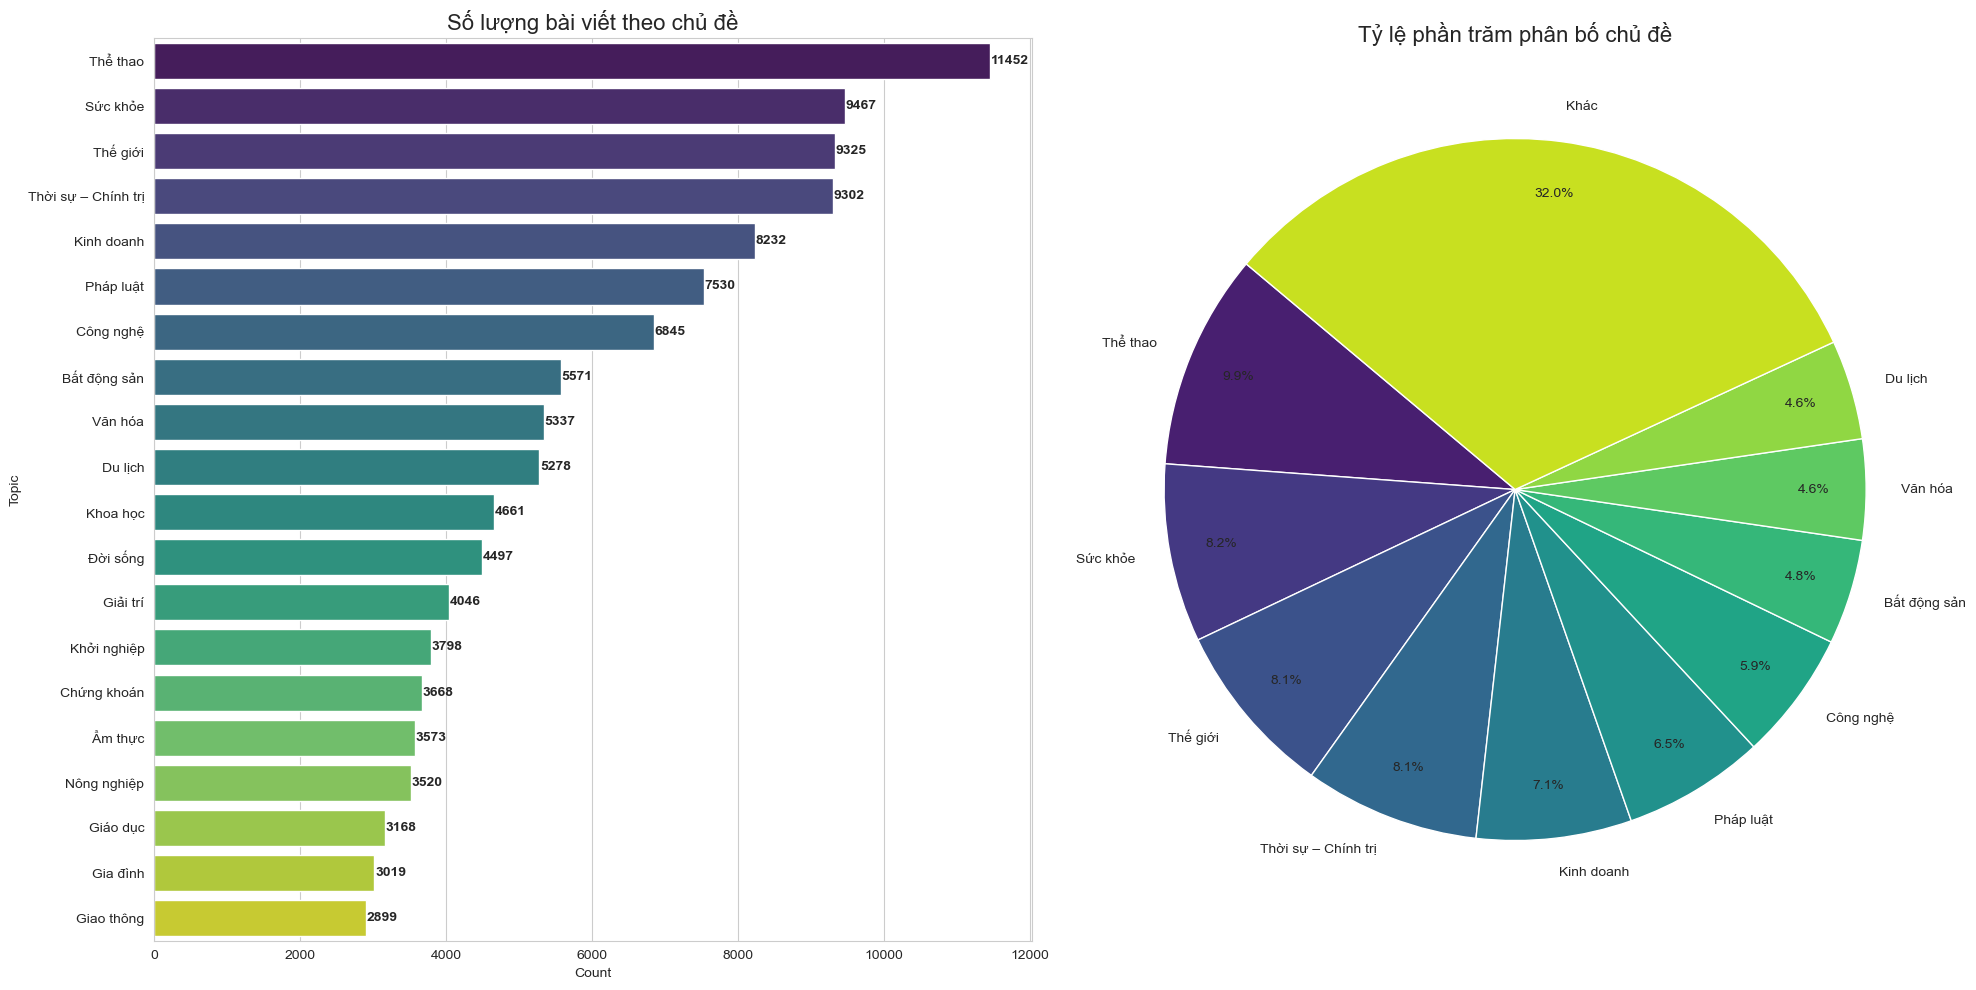

In [ ]:
# Thống kê số lượng
topic_counts = df[target_col].value_counts().reset_index()
topic_counts.columns = ['Topic', 'Count']
topic_counts['Percentage'] = (topic_counts['Count'] / topic_counts['Count'].sum()) * 100

print("Bảng thống kê phân bố nhãn:")
display(topic_counts)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 1. Bar Chart 
sns.barplot(x='Count', y='Topic', data=topic_counts, palette='viridis', ax=axes[0])
axes[0].set_title('Số lượng bài viết theo chủ đề', fontsize=16)
for i, v in enumerate(topic_counts['Count']):
    axes[0].text(v + 10, i, str(v), va='center', fontweight='bold')

# 2. Pie Chart (Tỷ lệ phần trăm)
if len(topic_counts) > 15:
    top_topics = topic_counts.head(10)
    other_count = topic_counts.iloc[10:]['Count'].sum()
    top_topics = pd.concat([top_topics, pd.DataFrame({'Topic': ['Khác'], 'Count': [other_count]})])
    data_pie = top_topics
else:
    data_pie = topic_counts

axes[1].pie(data_pie['Count'], labels=data_pie['Topic'], autopct='%1.1f%%', 
            colors=sns.color_palette('viridis', len(data_pie)), startangle=140, pctdistance=0.85)
axes[1].set_title('Tỷ lệ phần trăm phân bố chủ đề', fontsize=16)

plt.tight_layout()
plt.show()

# 3. PHÂN TÍCH ĐỘ DÀI VĂN BẢN (NÂNG CAO)
Sử dụng Histogram, Boxplot và CDF để đưa ra quyết định chính xác về tham số `MAX_LEN`.

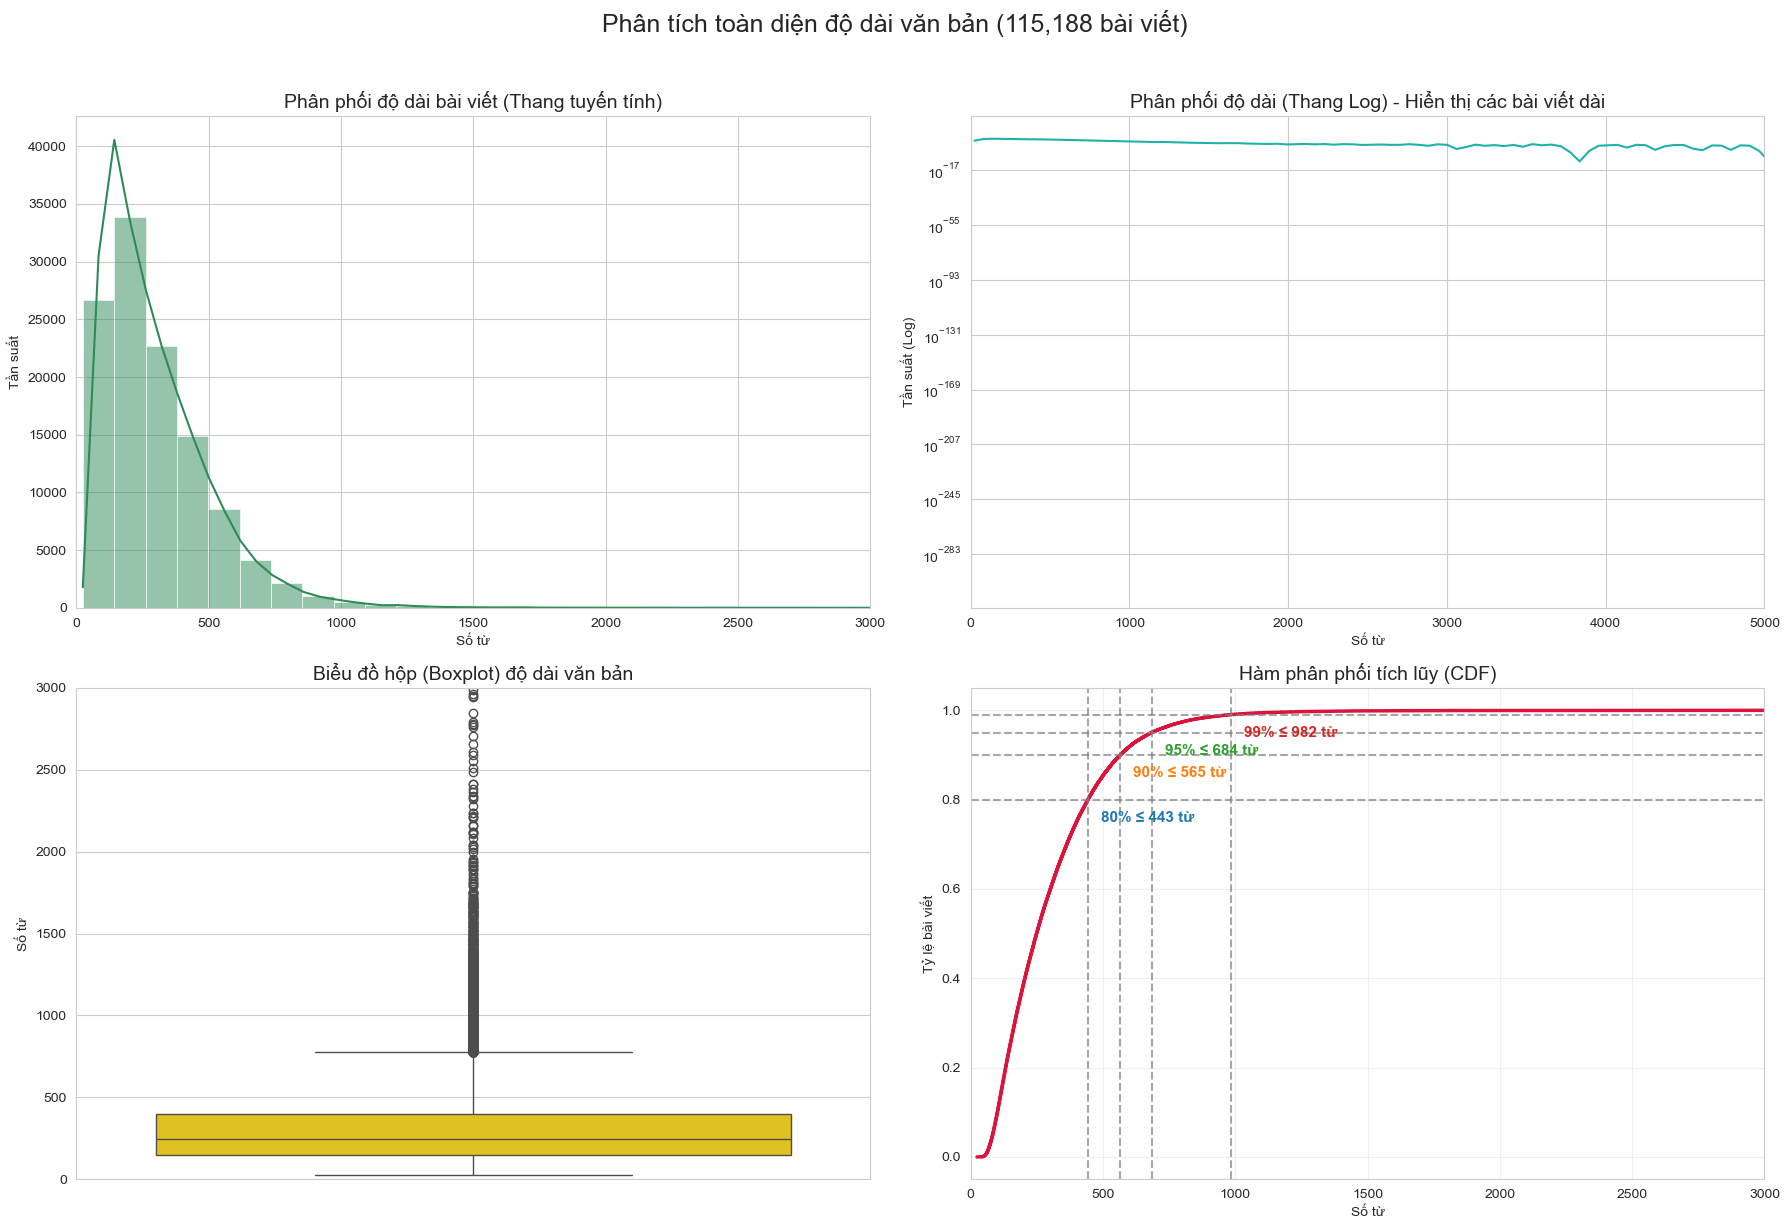

Bảng thống kê mô tả:
count    115188.000000
mean        301.904973
std         217.337005
min          24.000000
25%         149.000000
50%         249.000000
75%         400.000000
max       11876.000000
Name: word_count, dtype: float64

NHẬN ĐỊNH TỰ ĐỘNG CHO MÔ HÌNH:
- 80% bài viết ≤ 443 từ
- 90% bài viết ≤ 565 từ → Ngưỡng an toàn cho LSTM/BERT
- 95% bài viết ≤ 684 từ → Ngưỡng lý tưởng, bao phủ hầu hết dữ liệu
- 99% bài viết ≤ 982 từ → Chỉ 1% bài viết siêu dài bị cắt bỏ
- Bài dài nhất: 11876 từ


In [ ]:

df['word_count'] = df['text'].str.split().str.len()
df['word_count'] = df['word_count'].fillna(0).astype(int)

p80 = int(np.percentile(df['word_count'], 80))
p90 = int(np.percentile(df['word_count'], 90))
p95 = int(np.percentile(df['word_count'], 95))
p97 = int(np.percentile(df['word_count'], 97))
p99 = int(np.percentile(df['word_count'], 99))
p99_9 = int(np.percentile(df['word_count'], 99.9))

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Histogram (Thang đo tuyến tính)
sns.histplot(df['word_count'], bins=100, kde=True, color='#2E8B57', ax=axes[0,0])
axes[0,0].set_title('Phân phối độ dài bài viết (Thang tuyến tính)', fontsize=14)
axes[0,0].set_xlabel('Số từ')
axes[0,0].set_ylabel('Tần suất')
axes[0,0].set_xlim(0, 3000)

# 2. Histogram (Thang đo Logarit)
sns.histplot(df['word_count'], bins=100, kde=True, color='#20B2AA', log_scale=(False, True), ax=axes[0,1])
axes[0,1].set_title('Phân phối độ dài (Thang Log) - Hiển thị các bài viết dài', fontsize=14)
axes[0,1].set_xlabel('Số từ')
axes[0,1].set_ylabel('Tần suất (Log)')
axes[0,1].set_xlim(0, 5000)

# 3. Boxplot
sns.boxplot(y=df['word_count'], color='#FFD700', ax=axes[1,0])
axes[1,0].set_title('Biểu đồ hộp (Boxplot) độ dài văn bản', fontsize=14)
axes[1,0].set_ylabel('Số từ')
axes[1,0].set_ylim(0, 3000)

# 4. Hàm phân phối tích lũy (CDF) với các mốc percentile
sorted_lengths = np.sort(df['word_count'])
cdf = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
axes[1,1].plot(sorted_lengths, cdf, color='#DC143C', linewidth=2.5)
axes[1,1].set_title('Hàm phân phối tích lũy (CDF)', fontsize=14)
axes[1,1].set_xlabel('Số từ')
axes[1,1].set_ylabel('Tỷ lệ bài viết')
axes[1,1].set_xlim(0, 3000)
axes[1,1].grid(True, alpha=0.3)

# Đánh dấu các percentile quan trọng trên CDF
percentiles = [
    (0.80, p80, '80%', '#1f77b4'),
    (0.90, p90, '90%', '#ff7f0e'),
    (0.95, p95, '95%', '#2ca02c'),
    (0.99, p99, '99%', '#d62728')
]

for ratio, length, label, color in percentiles:
    axes[1,1].axhline(ratio, color='gray', linestyle='--', alpha=0.7)
    axes[1,1].axvline(length, color='gray', linestyle='--', alpha=0.7)
    axes[1,1].text(length + 50, ratio - 0.05, f'{label} ≤ {length} từ', 
                   fontsize=11, color=color, weight='bold')

plt.suptitle(f'Phân tích toàn diện độ dài văn bản ({len(df):,} bài viết)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# In thống kê chi tiết
print("Bảng thống kê mô tả:")
print(df['word_count'].describe())
print("\nNHẬN ĐỊNH TỰ ĐỘNG CHO MÔ HÌNH:")
print(f"- 80% bài viết ≤ {p80} từ")
print(f"- 90% bài viết ≤ {p90} từ → Ngưỡng an toàn cho LSTM/BERT")
print(f"- 95% bài viết ≤ {p95} từ → Ngưỡng lý tưởng, bao phủ hầu hết dữ liệu")
print(f"- 99% bài viết ≤ {p99} từ → Chỉ 1% bài viết siêu dài bị cắt bỏ")
print(f"- Bài dài nhất: {df['word_count'].max()} từ")

# 4. WORDCLOUD THEO CHỦ ĐỀ (TOPIC-SPECIFIC WORDCLOUDS)
Hiển thị các từ khóa đặc trưng nhất cho từng chủ đề để kiểm tra chất lượng dữ liệu.

Đang tạo WordCloud cho từng chủ đề...


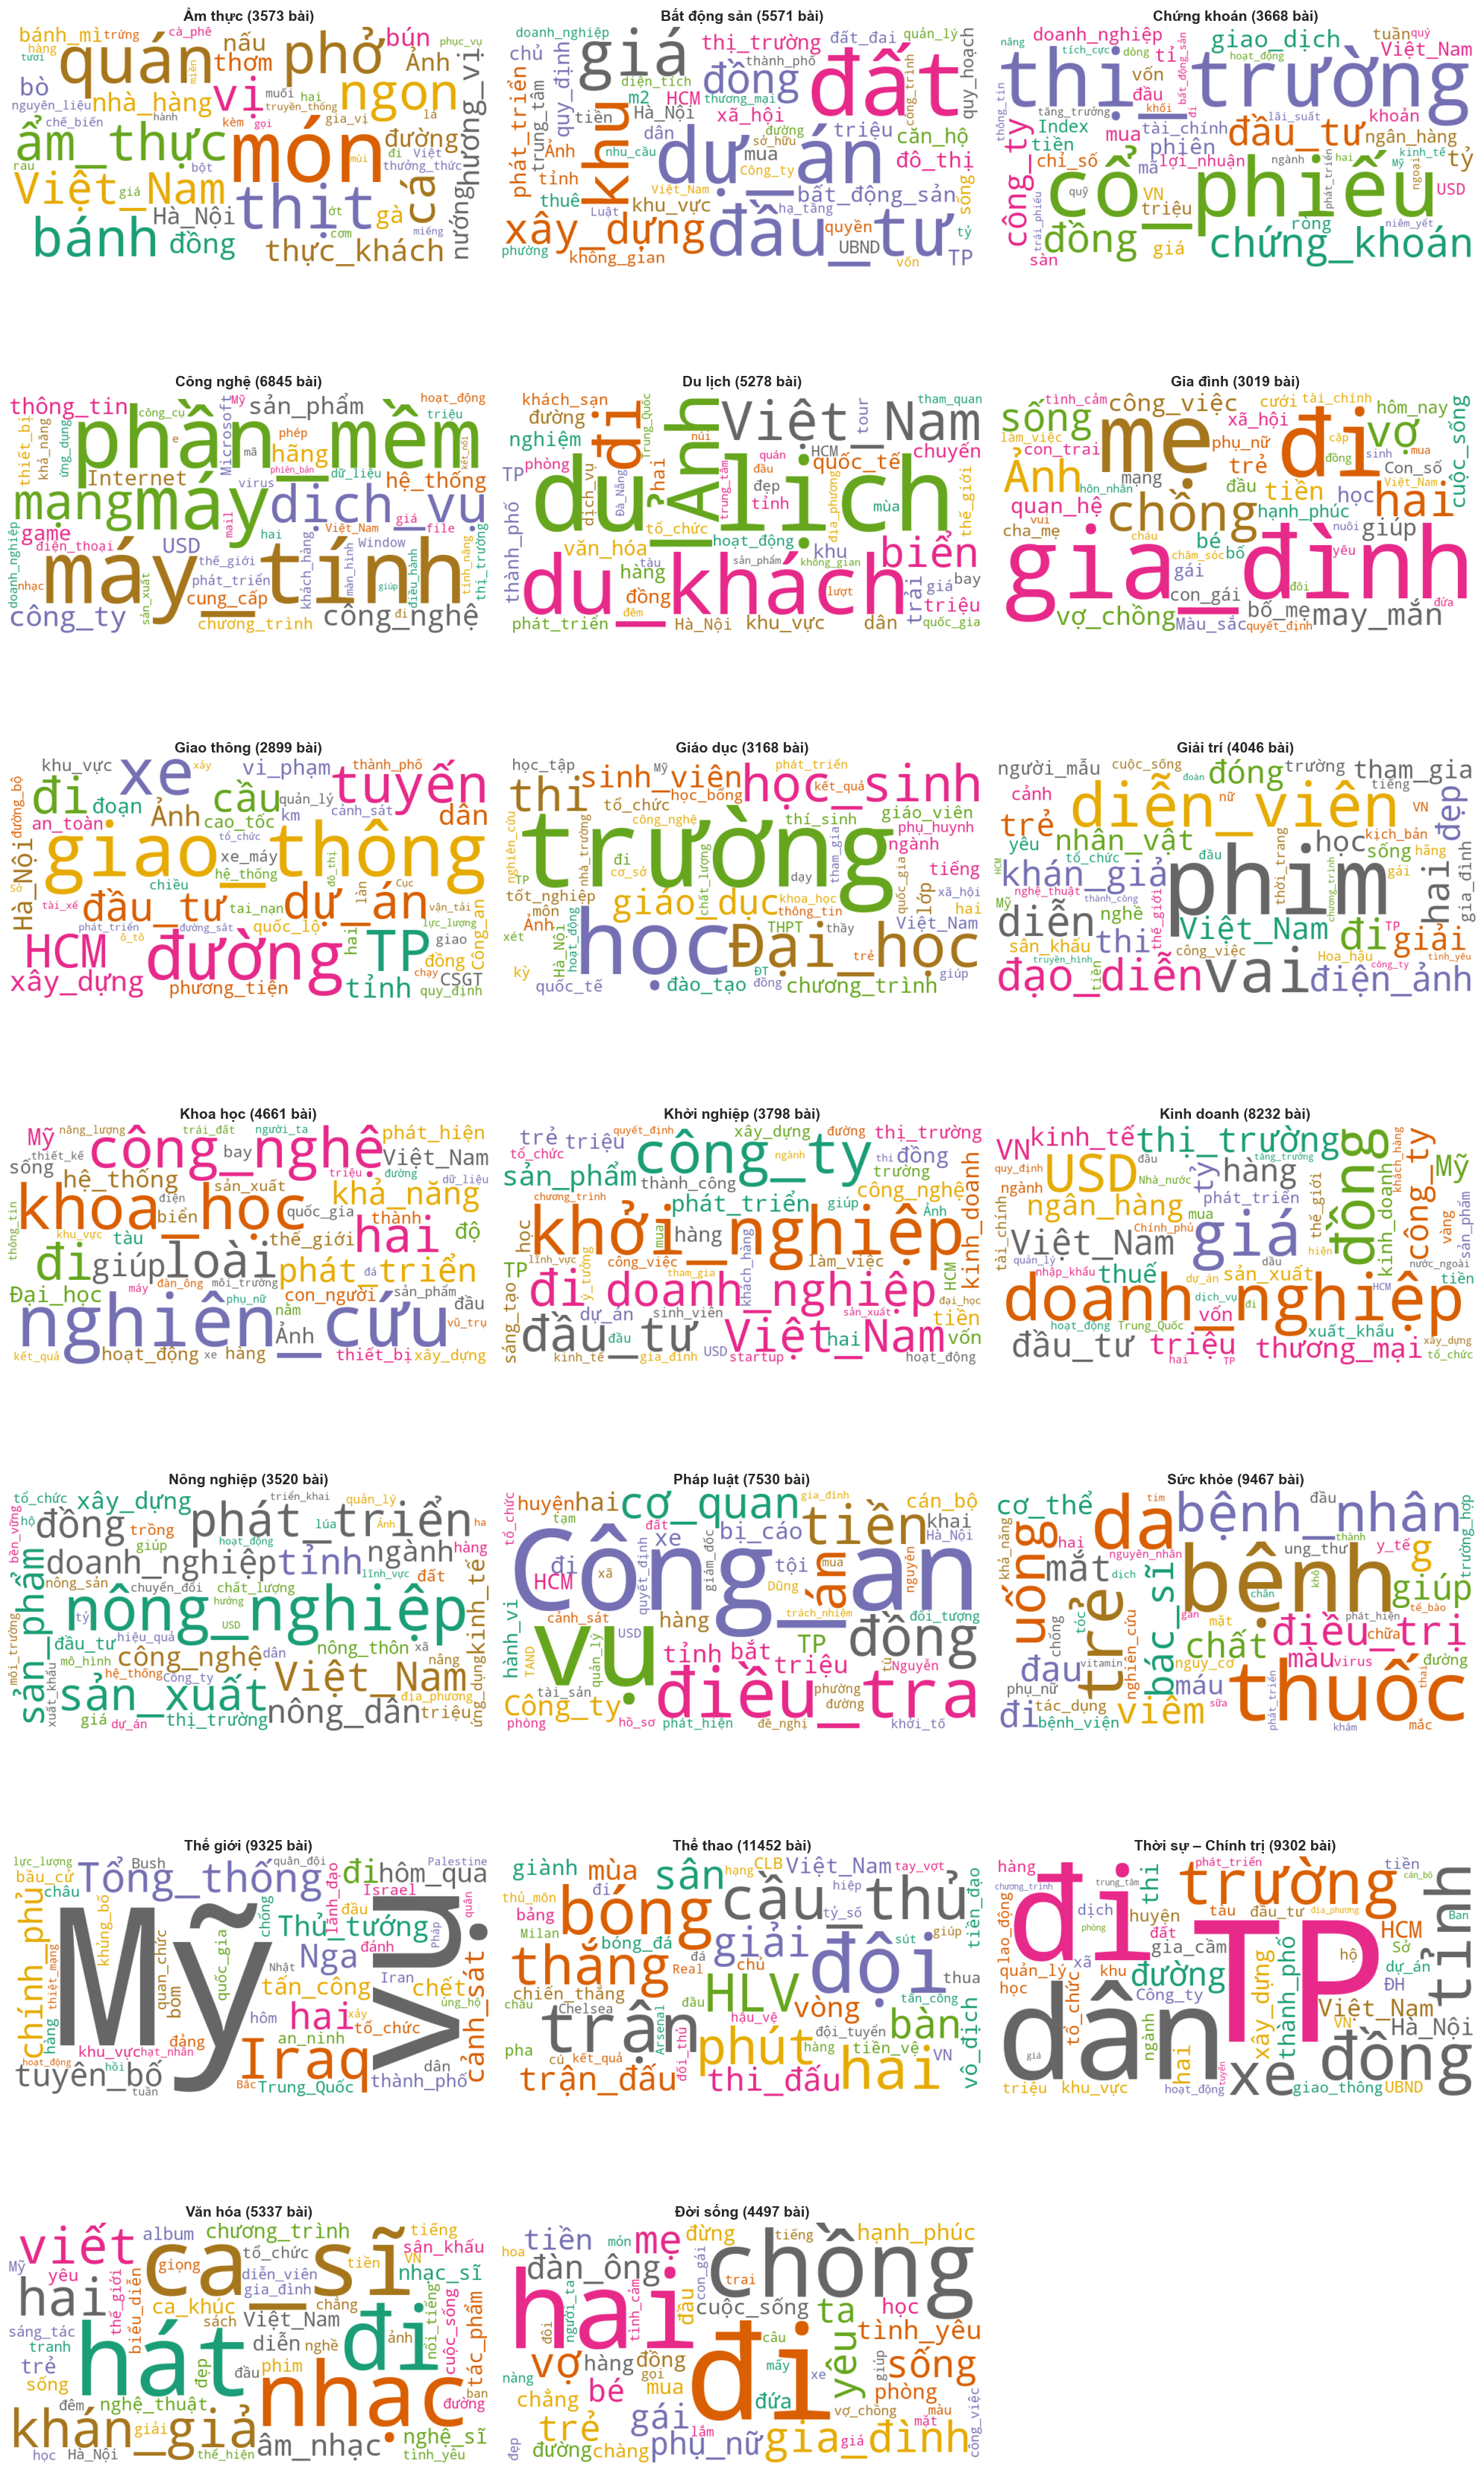

In [ ]:

unique_topics = df[target_col].unique()
n_topics = len(unique_topics)

n_cols = 3
n_rows = math.ceil(n_topics / n_cols)

plt.figure(figsize=(20, 5 * n_rows))

print("Đang tạo WordCloud cho từng chủ đề...")

for i, topic in enumerate(unique_topics):
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Lấy văn bản thuộc chủ đề hiện tại
    subset = df[df[target_col] == topic]
    text_subset = " ".join(text for text in subset['text'])
    
    # Tạo WordCloud
    wc = WordCloud(
        width=800, height=400, 
        background_color='white', 
        max_words=50, 
        colormap='Dark2',
        collocations=False
    ).generate(text_subset)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{topic} ({len(subset)} bài)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()